# Total LeNet-5 compression compare

In [34]:
PATH_PREFIX = '../../'
import sys
sys.path.append(PATH_PREFIX)

In [35]:
import torch
import torch.nn as nn
import pandas as pd
import os
import matplotlib.pyplot as plt

from data.mnist import MnistDataset
from data.utils.mnist_utils import *
from models.lenet.lenet import LeNet5
from utils.quantize import *
from utils.weight_sharing import *
from utils.plot import *

Setting parameters

In [36]:
# net settings
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = None
EPOCHS = 100
NET_TYPE = 'relu'

# search settings
SEARCH_RANGE = range(1, 51)
PRECISION_RED = 'f1'

NET_PATH =  os.path.join(PATH_PREFIX, f'models/lenet/saves/lenet_{NET_TYPE}.save')
SAVE_DATA = os.path.join(PATH_PREFIX, f'results/lenet_complete_share/complete_lenet_{NET_TYPE}_share_{PRECISION_RED}.csv')

Initing model and dataset

In [37]:
dataset = MnistDataset(BATCH_SIZE, os.path.join(PATH_PREFIX, 'data'), val_split=0.5)
model = LeNet5(N_CLASSES, NET_TYPE)
criterion = nn.CrossEntropyLoss()

lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

optimizer = lam_opt(model)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings)

ws_controller = WeightShare(model, lam_test, lam_opt, lam_train)
ws_controller.set_reset()
ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Computing bedore compression loss

In [38]:
before_acc = lam_test()
before_acc

0.9846

Load or create the data

In [39]:
if os.path.isfile(SAVE_DATA):
    df = pd.read_csv(SAVE_DATA)
else:
    df = {
        'num_vals': [],
        'compression': [],
        'accuracy': [],
        'inertia': [],
    }

    # generating data
    for value in SEARCH_RANGE:
        perf = ws_controller.share_total(value, prec_rtype=PRECISION_RED)
        ws_controller.reset()
        df['num_vals'].append(value)
        df['compression'].append(perf['compression'])
        df['accuracy'].append(perf['accuracy'])
        df['inertia'].append(perf['inertia'])

    df = pd.DataFrame(df)
    df['accuracy_loss'] = before_acc - df['accuracy']
    df.to_csv(SAVE_DATA)
df[df['accuracy_loss'] < 0.01].sort_values(by=['compression'], ascending=False)

,Unnamed: 0,num_vals,compression,accuracy,inertia,accuracy_loss
18,18,19,6.397627,0.9758,3.173073,0.0088
22,22,23,6.397128,0.9776,2.168691,0.0070
27,27,28,6.396504,0.9780,1.456303,0.0066
28,28,29,6.396379,0.9754,1.348875,0.0092
29,29,30,6.396254,0.9788,1.262608,0.0058
31,31,32,6.396004,0.9800,1.107792,0.0046
33,33,34,5.329894,0.9778,0.979223,0.0068
34,34,35,5.329793,0.9810,0.920638,0.0036
35,35,36,5.329692,0.9772,0.877601,0.0074
36,36,37,5.329591,0.9800,0.836325,0.0046


Plotting results

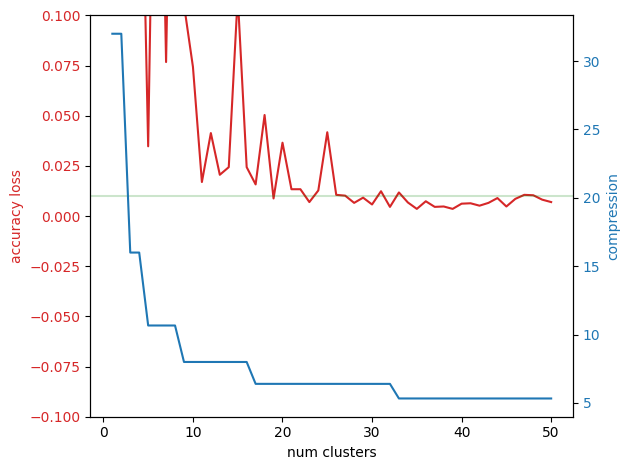

In [40]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('num clusters')
ax1.set_ylabel('accuracy loss', color=color)
ax1.plot(df['num_vals'], df['accuracy_loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim((-0.1, 0.1))
plt.axhline(0.01, color='green', alpha=0.2)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('compression', color=color)
ax2.plot(df['num_vals'], df['compression'], color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()
plt.show()

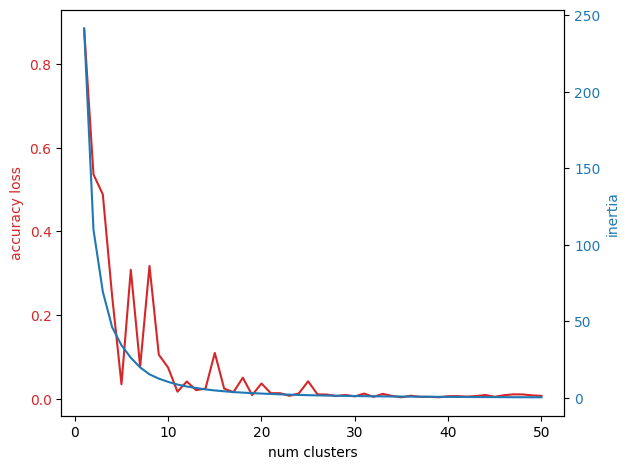

In [41]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('num clusters')
ax1.set_ylabel('accuracy loss', color=color)
ax1.plot(df['num_vals'], df['accuracy_loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_ylim((-0.1, 0.1))

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('inertia', color=color)
ax2.plot(df['num_vals'], df['inertia'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

Best compression above accuracy treshold

In [42]:
ACC_TRESHOLD = 0.01

df_f = df[df['accuracy_loss'] < ACC_TRESHOLD].sort_values('compression', ascending=False)
df_f.head()

,Unnamed: 0,num_vals,compression,accuracy,inertia,accuracy_loss
18,18,19,6.397627,0.9758,3.173073,0.0088
22,22,23,6.397128,0.9776,2.168691,0.0070
27,27,28,6.396504,0.9780,1.456303,0.0066
28,28,29,6.396379,0.9754,1.348875,0.0092
29,29,30,6.396254,0.9788,1.262608,0.0058


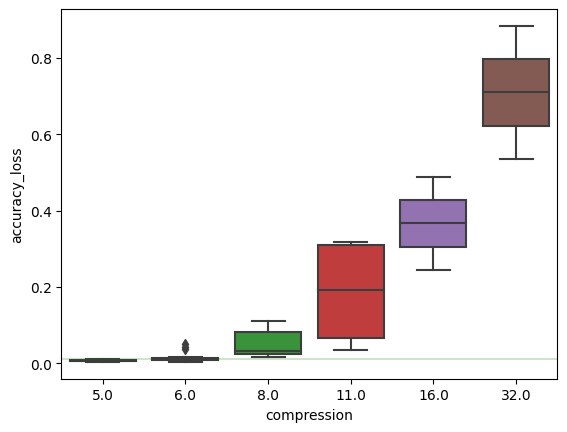

In [45]:
sns.boxplot(data=df.round({'compression': 0}), x='compression', y='accuracy_loss')
plt.axhline(0.01, color='green', alpha=0.2)

<AxesSubplot:xlabel='accuracy', ylabel='inertia'>

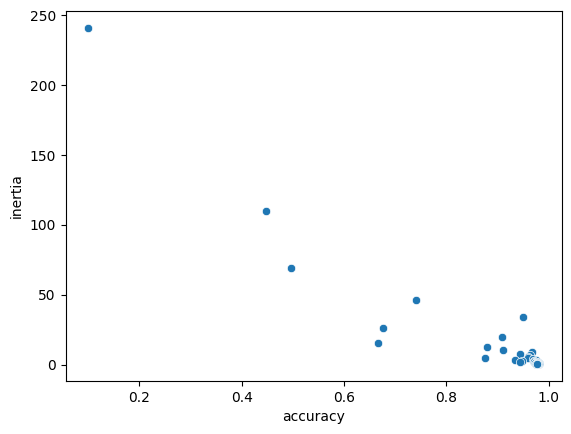

In [44]:
sns.scatterplot(data=df, x='accuracy', y='inertia')